In [1]:
'''
from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
'''

'\nfrom opt_einsum.paths import branch_1\n!apt-get update\n!apt-get install graphviz -y\n\n!pip install tensorflow\n!pip install numpy\n!pip install pandas\n\n!pip install keras\n!pip install scikit-learn\n!pip install matplotlib\n!pip install joblib\n!pip install pyarrow\n!pip install fastparquet\n!pip install scipy\n!pip install seaborn\n!pip install tqdm\n!pip install pydot\n!pip install tensorflow-io\n'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, LayerNormalization, Input, Activation, Lambda, Bidirectional, Add, MaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import json
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")

2024-11-10 22:44:08.491015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 22:44:08.491086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 22:44:08.491139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 22:44:08.502469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df


def add_solar_features(df):
    # Calcolo dell'angolo solare
    df['solar_angle'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Interazioni tra features rilevanti
    df['cloud_temp_interaction'] = df['cloudcover'] * df['temp']
    df['visibility_cloud_interaction'] = df['visibility'] * (100 - df['cloudcover'])

    # Feature derivate
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_gradient'] = df['temp'] - df['tempmin']

    return df


def add_solar_specific_features(df):
    # Angolo solare e durata del giorno
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = 12 - df['hour']
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Interazioni
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']

    # Rolling features con finestre più ampie
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()

    return df


def add_advanced_features(df):
    # Features esistenti
    df = add_time_features(df)
    df = add_solar_features(df)
    df = add_solar_specific_features(df)

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # One-hot encoding per le feature categoriche
    df = pd.get_dummies(df, columns=['season', 'time_period'])

    # Interazioni tra variabili meteorologiche
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']

    # Features derivate per la radiazione solare
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['day_length'] = np.sin(df['day_of_year_sin']) * 12 + 12  # approssimazione della durata del giorno

    # Lag features
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    # Rolling means
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()

    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100

    # Indicatore di condizioni estreme
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) & (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    # Feature composite per la trasparenza atmosferica
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    # Indicatori temporali più granulari per mezze stagioni
    df['is_transition_season'] = ((df['season_Spring'] | df['season_Autumn'])).astype(int)

    # Interazione tra angolo solare e copertura nuvolosa normalizzata
    df['solar_cloud_effect'] = df['solar_elevation'] * (100 - df['cloudcover']) / 100

    # Indicatore di stabilità atmosferica
    df['pressure_stability'] = df.groupby(df.index.date if isinstance(df.index, pd.DatetimeIndex)
                                          else df.index.to_series().dt.date)['pressure'].transform(
        lambda x: x.std()
    ).fillna(0)

    return df


def prepare_advanced_data(df):
    # Applicazione delle funzioni di feature engineering
    df = add_advanced_features(df)

    target_variables = ['solarradiation', 'solarenergy', 'uvindex']

    # Selezione delle feature più rilevanti per solarradiation
    selected_features = [
        # Features meteorologiche base
        'temp', 'humidity', 'cloudcover', 'visibility', 'pressure',

        # Features temporali cicliche
        'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
        'day_of_year_sin', 'day_of_year_cos',

        # Features solari
        'solar_angle', 'solar_elevation', 'day_length',
        'clear_sky_index', 'solar_noon',

        # Interazioni
        'cloud_temp_interaction', 'visibility_cloud_interaction',
        'cloud_elevation', 'visibility_elevation',

        # Rolling features
        'cloud_rolling_12h', 'temp_rolling_12h',
        'temp_rolling_mean_6h', 'cloudcover_rolling_mean_6h',

        # Features categoriche
        'season', 'time_period'
    ]

    # Aggiorna la lista delle feature con le colonne one-hot
    categorical_columns = [col for col in df.columns if col.startswith(('season_', 'time_period_'))]
    final_features = [f for f in selected_features if f not in ['season', 'time_period']] + categorical_columns

    df = df.sort_values('datetime')
    df.set_index('datetime', inplace=True)

    columns_to_interpolate = final_features + target_variables
    for column in columns_to_interpolate:
        df[column] = df[column].interpolate(method='time')

    # Rimuovi eventuali valori mancanti residui
    df.fillna(0, inplace=True)

    data_after_2010 = df[df['year'] >= 2010].copy()
    data_before_2010 = df[df['year'] < 2010].copy()

    print("\nNumero di record dopo 2010:", len(data_after_2010))
    print("Numero di record prima 2010:", len(data_before_2010))

    X = data_after_2010[final_features]

    y = data_after_2010['uvindex']

    X_to_predict = data_before_2010[final_features]

    # Split dei dati
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Scaling delle feature
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_to_predict_scaled = scaler.transform(X_to_predict)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, final_features, X_to_predict_scaled


def create_sequence_data(X, sequence_length=24):
    """
    Converte i dati in sequenze per l'input LSTM
    sequence_length rappresenta quante ore precedenti considerare
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):

    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convertiamo i dati in sequenze
    sequence_length = 24  # 24 ore di dati storici

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adattiamo le y rimuovendo i primi (sequence_length-1) elementi
    y_train = y_train[sequence_length - 1:]
    y_test = y_test[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq

In [8]:
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01, return_sequences=True):
    residual = x
    x = Bidirectional(LSTM(units, return_sequences=return_sequences, kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Adjust residual dimension and handle return_sequences
    if return_sequences:
        if int(residual.shape[-1]) != 2 * units:
            residual = Dense(2 * units, activation='linear')(residual)
        x = Add()([x, residual])
    return x


def attention_block(x, units, num_heads=8):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    x = Add()([x, attention])
    x = LayerNormalization()(x)
    return x


def create_solarradiation_index_model(input_shape, folder_name, l2_lambda=0.005):
    inputs = Input(shape=input_shape)

    # Primi due layer LSTM con sequenze
    x = create_residual_lstm_layer(inputs, 128, 0.4, l2_lambda, return_sequences=True)
    x = create_residual_lstm_layer(x, 64, 0.3, l2_lambda, return_sequences=True)
    x = create_residual_lstm_layer(x, 32, 0.2, l2_lambda, return_sequences=True)

    # Attention e MaxPooling mentre abbiamo ancora la sequenza
    x = attention_block(x, 32, num_heads=16)
    x = MaxPooling1D()(x)

    # Ultimo layer LSTM senza sequenze
    x = create_residual_lstm_layer(x, 32, 0.1, l2_lambda, return_sequences=False)

    # Dense layers
    x = Dense(32, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.1)(x)

    x = Dense(16, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    outputs = Lambda(lambda x: tf.clip_by_value(x, 0, 11))(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="UvModel")

    optimizer = AdamW(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=optimizer,
        loss='huber',
        metrics=['mae', 'mse']
    )
    model.summary()

    plot_model(model,
               to_file=f'{folder_name}_model_architecture.png',
               show_shapes=True,  # Mostra le dimensioni dei tensori
               show_layer_names=True,  # Mostra i nomi dei layer
               dpi=96,  # Risoluzione dell'immagine
               show_layer_activations=True)

    return model


def evaluate_solarradiation_predictions(y_true, y_pred, folder_name=None):
    """
    Valutazione specifica per UV index con metriche sia raw che categoriche

    Parameters:
    -----------
    y_true : array-like
        Valori reali dell'UV index
    y_pred : array-like
        Valori predetti dell'UV index
    folder_name : str, optional
        Cartella dove salvare eventuali plot di analisi

    Returns:
    --------
    dict
        Dizionario contenente tutte le metriche calcolate
    """
    import os
    from datetime import datetime

    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    # Calcolo metriche sui valori raw
    mae_raw = mean_absolute_error(y_true, y_pred)
    rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_raw = r2_score(y_true, y_pred)

    # Arrotonda le predizioni al più vicino intero
    y_pred_rounded = np.round(y_pred)
    y_pred_clipped = np.clip(y_pred_rounded, 0, 11)

    # Calcolo metriche sui valori arrotondati
    mae_rounded = mean_absolute_error(y_true, y_pred_clipped)
    rmse_rounded = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
    r2_rounded = r2_score(y_true, y_pred_clipped)

    # Calcolo accuratezza per diversi margini di errore (sia raw che rounded)
    # Raw
    within_05_raw = np.mean(np.abs(y_pred - y_true) <= 0.5)
    within_1_raw = np.mean(np.abs(y_pred - y_true) <= 1.0)
    within_2_raw = np.mean(np.abs(y_pred - y_true) <= 2.0)

    # Rounded
    exact_accuracy = np.mean(y_pred_clipped == y_true)
    one_off_accuracy = np.mean(np.abs(y_pred_clipped - y_true) <= 1)
    two_off_accuracy = np.mean(np.abs(y_pred_clipped - y_true) <= 2)

    print("\nUV Index Prediction Metrics:")
    print("\nRaw Predictions:")
    print(f"MAE: {mae_raw:.3f}")
    print(f"RMSE: {rmse_raw:.3f}")
    print(f"R² Score: {r2_raw:.3f}")
    print(f"Within ±0.5: {within_05_raw:.3f}")
    print(f"Within ±1.0: {within_1_raw:.3f}")
    print(f"Within ±2.0: {within_2_raw:.3f}")

    print("\nRounded Predictions:")
    print(f"MAE: {mae_rounded:.3f}")
    print(f"RMSE: {rmse_rounded:.3f}")
    print(f"R² Score: {r2_rounded:.3f}")
    print(f"Exact Match: {exact_accuracy:.3f}")
    print(f"±1 Accuracy: {one_off_accuracy:.3f}")
    print(f"±2 Accuracy: {two_off_accuracy:.3f}")

    # Analisi dei livelli UV
    def get_solarradiation_level(value):
        if value <= 2:
            return 'Low'
        elif value <= 5:
            return 'Moderate'
        elif value <= 7:
            return 'High'
        elif value <= 10:
            return 'Very High'
        else:
            return 'Extreme'

    # Calcola livelli UV sia per raw che rounded
    y_true_levels = [get_solarradiation_level(v) for v in y_true]
    y_pred_levels_raw = [get_solarradiation_level(v) for v in y_pred]
    y_pred_levels_rounded = [get_solarradiation_level(v) for v in y_pred_clipped]

    # Calcola accuracy dei livelli
    level_accuracy_raw = np.mean([t == p for t, p in zip(y_true_levels, y_pred_levels_raw)])
    level_accuracy_rounded = np.mean([t == p for t, p in zip(y_true_levels, y_pred_levels_rounded)])

    print("\nUV Level Accuracy:")
    print(f"Raw predictions: {level_accuracy_raw:.3f}")
    print(f"Rounded predictions: {level_accuracy_rounded:.3f}")

    print("\nUV Level Confusion Matrix (Raw Predictions):")
    print(pd.crosstab(
        pd.Series(y_true_levels, name='Actual'),
        pd.Series(y_pred_levels_raw, name='Predicted')
    ))

    print("\nUV Level Confusion Matrix (Rounded Predictions):")
    print(pd.crosstab(
        pd.Series(y_true_levels, name='Actual'),
        pd.Series(y_pred_levels_rounded, name='Predicted')
    ))

    # Se specificata una cartella, salva i plot di analisi
    if folder_name is not None:
        try:
            os.makedirs(folder_name, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

            # Plot di confronto tra raw e rounded predictions
            plt.figure(figsize=(15, 5))

            # Plot 1: Scatter plot confronto
            plt.subplot(1, 3, 1)
            plt.scatter(y_true, y_pred, alpha=0.5, label='Raw')
            plt.scatter(y_true, y_pred_clipped, alpha=0.5, label='Rounded')
            plt.plot([0, 11], [0, 11], 'r--', lw=2)
            plt.xlabel('Actual UV Index')
            plt.ylabel('Predicted UV Index')
            plt.title('Raw vs Rounded Predictions')
            plt.legend()
            plt.grid(True)

            # Plot 2: Distribuzione errori raw
            plt.subplot(1, 3, 2)
            plt.hist(y_pred - y_true, bins=50, alpha=0.7)
            plt.xlabel('Prediction Error (Raw)')
            plt.ylabel('Frequency')
            plt.title('Distribution of Raw Errors')
            plt.grid(True)

            # Plot 3: Distribuzione errori rounded
            plt.subplot(1, 3, 3)
            plt.hist(y_pred_clipped - y_true, bins=50, alpha=0.7)
            plt.xlabel('Prediction Error (Rounded)')
            plt.ylabel('Frequency')
            plt.title('Distribution of Rounded Errors')
            plt.grid(True)

            plt.tight_layout()

            # Salva il plot
            filename = os.path.join(folder_name, f'solarradiation_prediction_analysis_{timestamp}.png')
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot di analisi salvato come: {filename}")

            plt.show()

        except Exception as e:
            print(f"\nErrore nel salvare i plot: {str(e)}")

    # Restituisci tutte le metriche in un dizionario
    metrics = {
        'raw': {
            'mae': mae_raw,
            'rmse': rmse_raw,
            'r2': r2_raw,
            'within_05': within_05_raw,
            'within_1': within_1_raw,
            'within_2': within_2_raw,
            'level_accuracy': level_accuracy_raw
        },
        'rounded': {
            'mae': mae_rounded,
            'rmse': rmse_rounded,
            'r2': r2_rounded,
            'exact_match': exact_accuracy,
            'one_off': one_off_accuracy,
            'two_off': two_off_accuracy,
            'level_accuracy': level_accuracy_rounded
        }
    }

    return metrics

def plot_training_history(history, folder_name=None):
    """
    Visualizza e salva i plot della loss e delle metriche durante il training

    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        L'oggetto history restituito dal training del modello
    folder_name : str
        Cartella dove salvare il plot
    """
    import os

    try:
        # Crea la figura
        plt.figure(figsize=(12, 4))

        # Plot della Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot del MAE
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        if folder_name is not None:
            os.makedirs(folder_name, exist_ok=True)
            # Genera il nome del file con timestamp
            filename = os.path.join(folder_name, 'training_history.png')

            # Salva la figura
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot della training history salvato come: {filename}")

        # Salva anche i dati numerici in formato CSV
        history_df = pd.DataFrame({
            'epoch': range(1, len(history.history['loss']) + 1),
            'training_loss': history.history['loss'],
            'validation_loss': history.history['val_loss'],
            'training_mae': history.history['mae'],
            'validation_mae': history.history['val_mae']
        })

        if folder_name is not None:
            csv_filename = os.path.join(folder_name, 'training_history.csv')
            history_df.to_csv(csv_filename, index=False)
            print(f"Dati della training history salvati come: {csv_filename}")

        # Calcola e salva le statistiche finali
        final_stats = {
            'final_training_loss': history.history['loss'][-1],
            'final_validation_loss': history.history['val_loss'][-1],
            'final_training_mae': history.history['mae'][-1],
            'final_validation_mae': history.history['val_mae'][-1],
            'best_validation_loss': min(history.history['val_loss']),
            'best_validation_mae': min(history.history['val_mae']),
            'epochs': len(history.history['loss']),
        }

        if folder_name is not None:
            # Salva le statistiche in formato JSON
            stats_filename = os.path.join(folder_name, 'training_stats.json')
            with open(stats_filename, 'w') as f:
                json.dump(final_stats, f, indent=4)
            print(f"Statistiche finali salvate come: {stats_filename}")

        # Stampa le statistiche principali
        print("\nStatistiche finali del training:")
        print(f"Loss finale (train/val): {final_stats['final_training_loss']:.4f}/{final_stats['final_validation_loss']:.4f}")
        print(f"MAE finale (train/val): {final_stats['final_training_mae']:.4f}/{final_stats['final_validation_mae']:.4f}")
        print(f"Miglior validation loss: {final_stats['best_validation_loss']:.4f}")
        print(f"Miglior validation MAE: {final_stats['best_validation_mae']:.4f}")

        plt.show()

    except Exception as e:
        print(f"\nErrore durante la creazione o il salvataggio dei plot: {str(e)}")


def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='solarradiation_index'):
    """
    Funzione di training avanzata per il modello ibrido UV index con monitoraggio dettagliato
    e gestione del training.

    Parameters:
    -----------
    model : keras.Model
        Il modello ibrido compilato
    X_train : numpy.ndarray
        Dati di training
    y_train : numpy.ndarray
        Target di training
    X_test : numpy.ndarray
        Dati di validation
    y_test : numpy.ndarray
        Target di validation
    epochs : int, optional
        Numero massimo di epoche di training
    batch_size : int, optional
        Dimensione del batch

    Returns:
    --------
    history : keras.callbacks.History
        Storia del training con tutte le metriche
    """

    # Callbacks avanzati per il training
    callbacks = [
        # Early Stopping avanzato
        EarlyStopping(
            monitor='mae',
            patience=15,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-6
        ),
        ReduceLROnPlateau(
            monitor='mae',
            factor=0.05,
            patience=3,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=2,
            min_lr=1e-7
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            mode='min',
            min_delta=1e-6,
            cooldown=1,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_solarradiation_model.h5',
            monitor='mae',
            save_best_only=True,
            mode='min'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs_{folder_name}',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: print(
                f"\nEpoch {epoch + 1}: Predizioni fuori range: "
                f"{np.sum((model.predict(X_test) < 0) | (model.predict(X_test) > 11))}"
            ) if epoch % 20 == 0 else None
        )
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False,
            validation_freq=1,
        )

        # Analisi post-training
        print("\nTraining completato con successo!")

        # Valutazione finale sul test set
        test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nMetriche finali sul test set:")
        print(f"Loss: {test_loss:.4f}")
        print(f"MAE: {test_mae:.4f}")
        print(f"MSE: {test_mse:.4f}")

        # Analisi delle predizioni
        predictions = model.predict(X_test)
        out_of_range = np.sum((predictions < 0) | (predictions > 11))
        print(f"\nPredizioni fuori range: {out_of_range} ({out_of_range / len(predictions) * 100:.2f}%)")

        plot_training_history(history, folder_name=folder_name)

        return history

    except Exception as e:
        print(f"\nErrore durante il training: {str(e)}")
        raise

    finally:
        # Pulizia della memoria
        tf.keras.backend.clear_session()


def calculate_class_weights(y_train, n_classes=12):
    """
    Calcola i pesi delle classi per bilanciare il dataset UV index.
    
    Parameters:
    -----------
    y_train : numpy.ndarray
        Array dei valori UV di training
    n_classes : int, optional
        Numero di classi possibili (0-11 per UV index, quindi 12 classi)
        
    Returns:
    --------
    dict:
        Dizionario con i pesi per ogni classe
    """
    # Arrotonda i valori UV al più vicino intero e converti in intero
    y_discrete = np.clip(np.round(y_train), 0, 11).astype(int)

    # Calcola la frequenza di ogni classe
    unique, counts = np.unique(y_discrete, return_counts=True)
    total_samples = len(y_discrete)

    # Calcola i pesi inversamente proporzionali alla frequenza
    weights = {}
    for i in range(n_classes):
        if i in unique:
            # Se la classe è presente, calcola il peso
            weight = total_samples / (len(unique) * counts[unique == i][0])
        else:
            # Se la classe non è presente, assegna un peso neutro
            weight = 1.0
        weights[i] = weight

    return weights


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integra le predizioni dell'UV index nel dataset originale per i dati precedenti al 2010.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset originale
    predictions : numpy.ndarray
        Array delle predizioni UV index
    sequence_length : int
        Lunghezza della sequenza usata per le predizioni
        
    Returns:
    --------
    pandas.DataFrame
        Dataset aggiornato con le predizioni UV index
    """
    # Converti datetime in formato datetime se non lo è già
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identifica le righe precedenti al 2010
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Crea un DataFrame temporaneo con le predizioni
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'uvindex_predicted': predictions.flatten()
    })

    # Merge con il dataset originale
    df = df.merge(predictions_df, on='datetime', how='left')

    # Aggiorna la colonna uvindex dove manca
    df['uvindex'] = df['uvindex'].fillna(df['uvindex_predicted'])

    # Rimuovi la colonna temporanea
    df = df.drop('uvindex_predicted', axis=1)

    print(f"Aggiunte {len(predictions)} predizioni al dataset")
    print(f"Righe con UV index dopo l'integrazione: {df['uvindex'].notna().sum()}")

    return df


def train_uvindex_bounded_model(df):
    """
    Training del modello con vincoli specifici per UV index
    """
    print("Inizializzazione del training del modello UV index...")

    try:

        # Preparazione dei dati
        print("\n1. Preparazione dei dati...")
        X_train_seq, X_test_seq, y_train, y_test, scaler, features, X_to_predict_seq = prepare_hybrid_data(df)

        print(f"Shape dei dati di training: {X_train_seq.shape}")
        print(f"Shape dei dati di test: {X_test_seq.shape}")

        # Verifica della qualità dei dati
        if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
            raise ValueError("Trovati valori NaN nei dati di training")

        # Creazione del modello
        print("\n2. Creazione del modello...")
        input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        model = create_solarradiation_index_model(input_shape, folder_name)

        print("\n4. Avvio del training...")
        history = train_hybrid_model(
            model=model,
            X_train=X_train_seq,
            y_train=y_train,
            X_test=X_test_seq,
            y_test=y_test,
            epochs=100,
            batch_size=128,
            folder_name=folder_name
        )

        print("\n5. Generazione delle predizioni...")
        predictions = model.predict(X_test_seq)
        predictions = np.clip(predictions, 0, 11)

        print("\n6. Valutazione del modello...")
        metrics = evaluate_solarradiation_predictions(y_test, predictions, folder_name=folder_name)

        # Creazione del dizionario dei risultati
        training_results = {
            'model_params': {
                'input_shape': input_shape,
                'n_features': len(features),
                'sequence_length': X_train_seq.shape[1]
            },
            'training_params': {
                'batch_size': 32,
                'total_epochs': len(history.history['loss']),
                'best_epoch': np.argmin(history.history['val_loss']) + 1,
                #'class_weights': {str(k): float(v) for k, v in class_weights.items()}
            },
            'performance_metrics': {
                'final_loss': float(history.history['val_loss'][-1]),
                'final_mae': float(history.history['val_mae'][-1]),
                'best_val_loss': float(min(history.history['val_loss'])),
                'out_of_range_predictions': int(np.sum((predictions < 0) | (predictions > 11)))
            }
        }

        print("\n7. Predizione dei dati mancanti risultati...")
        to_predict_predictions = model.predict(X_to_predict_seq)
        to_predict_predictions = np.clip(to_predict_predictions, 0, 11)

        print("\n8. Integrazione delle predizioni nel dataset originale...")
        df_updated = integrate_predictions(df.copy(), to_predict_predictions)

        df_updated.to_parquet('./data/weather_data_uvindex.parquet')

        # Aggiungi statistiche sulle predizioni al training_results
        training_results['prediction_stats'] = {
            'n_predictions_added': len(to_predict_predictions),
            'mean_predicted_uv': float(to_predict_predictions.mean()),
            'min_predicted_uv': float(to_predict_predictions.min()),
            'max_predicted_uv': float(to_predict_predictions.max()),
        }

        print("\nTraining completato con successo!")

        return model, scaler, features, history, predictions, y_test, metrics, training_results

    except Exception as e:
        print(f"\nErrore durante il training: {str(e)}")
        raise

    finally:
        # Pulizia della memoria
        tf.keras.backend.clear_session()

Inizializzazione del training del modello UV index...

1. Preparazione dei dati...

Numero di record dopo 2010: 129777
Numero di record prima 2010: 227902
Shape dei dati di training: (64865, 24, 33)
Shape dei dati di test: (64866, 24, 33)

2. Creazione del modello...


2024-11-10 22:48:30.467084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:e1:00.0, compute capability: 8.6
2024-11-10 22:48:30.995563: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "UvModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 33)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 24, 256)              165888    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 layer_normalization (Layer  (None, 24, 256)              512       ['bidirectional[0][0]']       
 Normalization)                                                                                   
                                                                                            

2024-11-10 22:48:44.916189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-10 22:48:47.364274: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb501567b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-10 22:48:47.364334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-10 22:48:47.375943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-10 22:48:47.576847: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 [==============================] - ETA: 0s - loss: 3.0211 - mae: 0.8732 - mse: 2.6901

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2028/2028 [==============================] - 22s 11ms/step

Epoch 1: Predizioni fuori range: 0
507/507 [==============================] - 95s 149ms/step - loss: 3.0211 - mae: 0.8732 - mse: 2.6901 - val_loss: 1.1114 - val_mae: 0.5132 - val_mse: 0.8839 - lr: 5.0000e-04
Epoch 2/100
507/507 [==============================] - 23s 46ms/step - loss: 0.8217 - mae: 0.5744 - mse: 1.1119 - val_loss: 0.5794 - val_mae: 0.5285 - val_mse: 0.8990 - lr: 5.0000e-04
Epoch 3/100
507/507 [==============================] - 23s 45ms/step - loss: 0.5241 - mae: 0.5406 - mse: 0.9968 - val_loss: 0.4411 - val_mae: 0.4995 - val_mse: 0.8515 - lr: 5.0000e-04
Epoch 4/100
507/507 [==============================] - 23s 45ms/step - loss: 0.4490 - mae: 0.5363 - mse: 0.9738 - val_loss: 0.3752 - val_mae: 0.4606 - val_mse: 0.7784 - lr: 5.0000e-04
Epoch 5/100
507/507 [==============================] - 23s 45ms/step - loss: 0.4127 - mae: 0.5218 - mse: 0.9290 - val_loss: 0.3470 - val_mae: 0.4698 - val_mse: 0.7271 - lr: 5.0000e

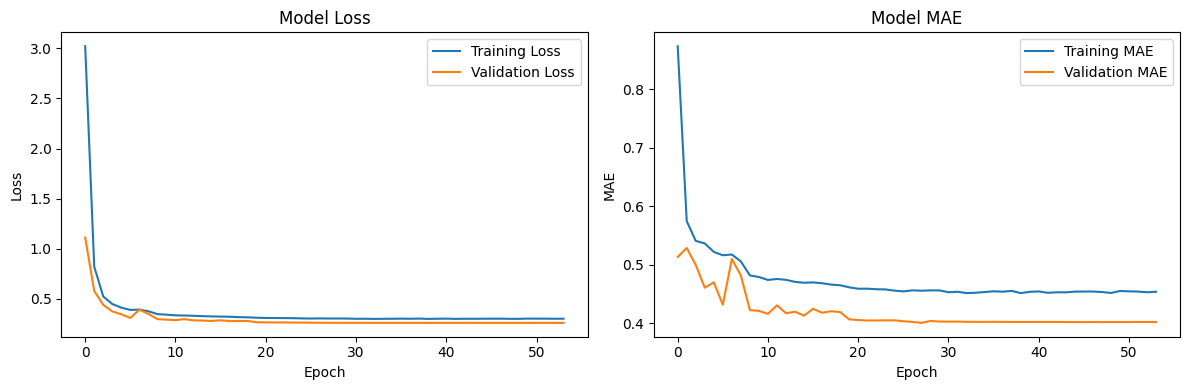


5. Generazione delle predizioni...
2028/2028 [==============================] - 23s 11ms/step

6. Valutazione del modello...

UV Index Prediction Metrics:
MAE: 0.384
RMSE: 0.809
R² Score: 0.911
Exact Match Accuracy: 0.331
±1 Accuracy: 0.458
±2 Accuracy: 0.566

UV Level Confusion Matrix:
Predicted  High    Low  Moderate  Very High
Actual                                     
High       3134     11      1252        481
Low         129  43324      1888         19
Moderate   1208   1663      7320        152
Very High  1188      1        78       3018

7. Visualizzazione risultati...


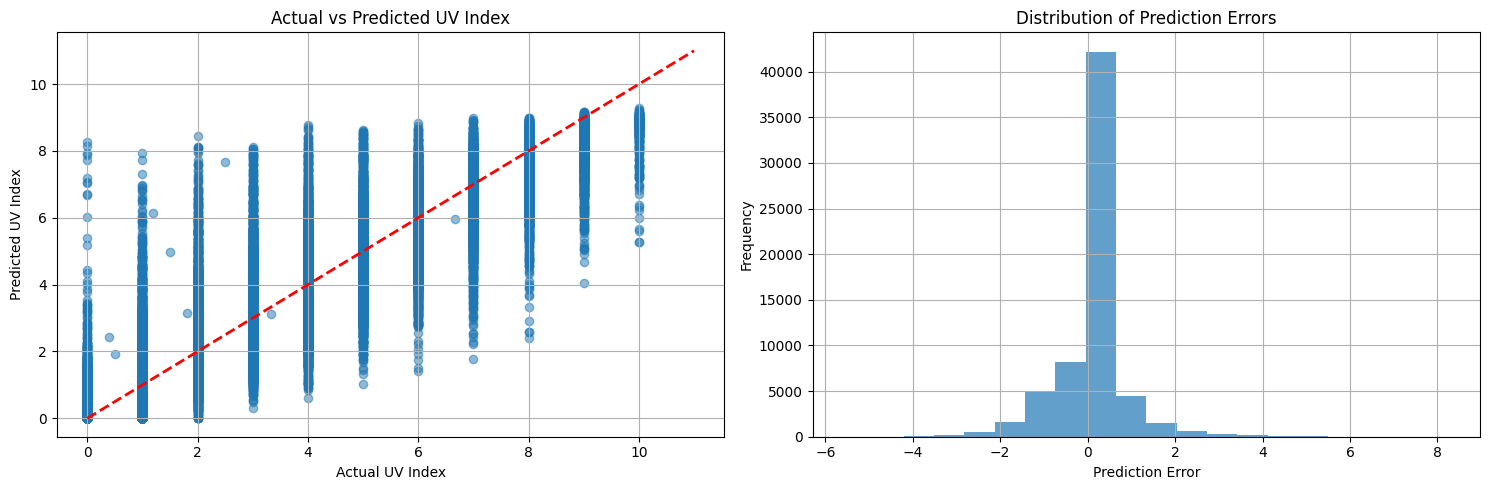


8. Predizione dei dati mancanti risultati...
7122/7122 [==============================] - 78s 11ms/step

9. Integrazione delle predizioni nel dataset originale...
Aggiunte 227879 predizioni al dataset
Righe con UV index dopo l'integrazione: 357615

Training completato con successo!


In [9]:
df = pd.read_parquet('../data/weather_data.parquet')

# Esegui il training
model, scaler, features, history, predictions, y_test, metrics, training_results = train_uvindex_bounded_model(df)

In [10]:
def analyze_solarradiation_prediction_quality(y_true, y_pred):
    """
    Analisi dettagliata della qualità delle predizioni UV
    """
    # Converti in numpy array e appiattisci
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    # Arrotonda le predizioni al più vicino 0.5
    y_pred_rounded = np.round(y_pred * 2) / 2

    # Calcola diverse metriche di accuratezza usando array numpy
    exact_match = np.mean(np.abs(y_pred_rounded - y_true) < 1e-6) * 100  # uso di tolleranza per confronti float
    within_half = np.mean(np.abs(y_pred_rounded - y_true) <= 0.5) * 100
    within_one = np.mean(np.abs(y_pred_rounded - y_true) <= 1.0) * 100

    # Analisi per livello di rischio UV
    def get_solarradiation_risk_level(values):
        # Vettorizzazione della funzione per array numpy
        levels = np.zeros_like(values, dtype=str)
        levels[values <= 2] = 'Basso'
        levels[(values > 2) & (values <= 5)] = 'Moderato'
        levels[(values > 5) & (values <= 7)] = 'Alto'
        levels[(values > 7) & (values <= 10)] = 'Molto Alto'
        levels[values > 10] = 'Estremo'
        return levels

    y_true_risk = get_solarradiation_risk_level(y_true)
    y_pred_risk = get_solarradiation_risk_level(y_pred_rounded)

    risk_accuracy = np.mean(y_true_risk == y_pred_risk) * 100

    print("Analisi Precisione Predizioni UV Index:")
    print(f"Precisione esatta: {exact_match:.1f}%")
    print(f"Precisione entro 0.5 punti: {within_half:.1f}%")
    print(f"Precisione entro 1.0 punti: {within_one:.1f}%")
    print(f"Precisione livello di rischio: {risk_accuracy:.1f}%")

    # Distribuzione degli errori per livello UV
    solarradiation_ranges = [(0, 2), (2, 5), (5, 7), (7, 10), (10, 11)]
    labels = ['Basso', 'Moderato', 'Alto', 'Molto Alto', 'Estremo']

    print("\nAnalisi errori per livello UV:")
    for (low, high), label in zip(solarradiation_ranges, labels):
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            mae_range = np.mean(np.abs(y_pred[mask] - y_true[mask]))
            n_samples = np.sum(mask)
            print(f"MAE per UV {label} ({low}-{high}): {mae_range:.3f} (n={n_samples})")

    # Analisi aggiuntiva della distribuzione degli errori
    errors = y_pred - y_true
    print("\nStatistiche degli errori:")
    print(f"Media errori: {np.mean(errors):.3f}")
    print(f"Deviazione standard errori: {np.std(errors):.3f}")
    print(f"Errore mediano: {np.median(errors):.3f}")
    print(f"95° percentile errore assoluto: {np.percentile(np.abs(errors), 95):.3f}")

    return {
        'exact_match': exact_match,
        'within_half': within_half,
        'within_one': within_one,
        'risk_accuracy': risk_accuracy,
        'error_stats': {
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'median': float(np.median(errors)),
            'p95_abs': float(np.percentile(np.abs(errors), 95))
        }
    }


# Per utilizzare l'analisi:
metrics = analyze_solarradiation_prediction_quality(y_test, predictions)

Analisi Precisione Predizioni UV Index:
Precisione esatta: 61.3%
Precisione entro 0.5 punti: 79.4%
Precisione entro 1.0 punti: 90.4%
Precisione livello di rischio: 88.0%

Analisi errori per livello UV:
MAE per UV Basso (0-2): 0.138 (n=41346)
MAE per UV Moderato (2-5): 0.906 (n=11522)
MAE per UV Alto (5-7): 0.877 (n=5468)
MAE per UV Molto Alto (7-10): 0.758 (n=6278)
MAE per UV Estremo (10-11): 1.528 (n=252)

Statistiche degli errori:
Media errori: 0.006
Deviazione standard errori: 0.783
Errore mediano: 0.000
95° percentile errore assoluto: 1.723


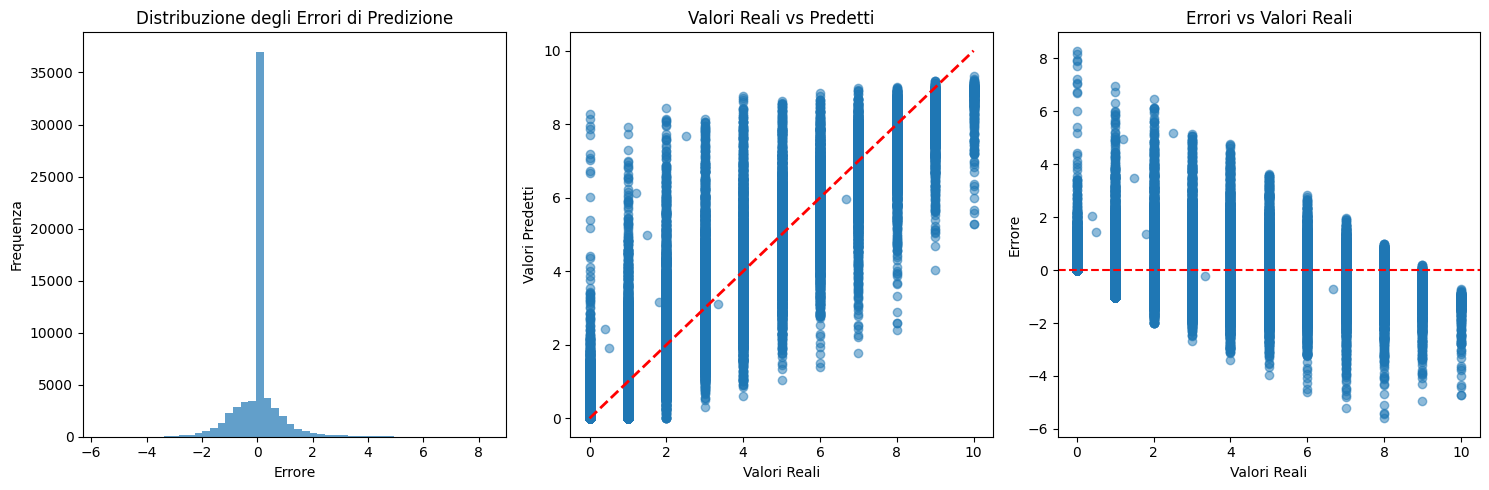


Statistiche degli errori:
MAE: 0.4021
MSE: 0.6128
RMSE: 0.7828
Media errori: 0.0062
Std errori: 0.7828
Predizioni entro ±0.5: 71.1%
Predizioni entro ±1.0: 86.1%
Predizioni entro ±1.5: 93.2%
Predizioni entro ±2.0: 96.5%


In [11]:
def plot_error_analysis(y_true, y_pred, folder_name=None):
    """
    Funzione per visualizzare l'analisi degli errori di predizione

    Parameters:
    -----------
    y_true : array-like
        Valori reali
    y_pred : array-like
        Valori predetti
    folder_name : str, optional
        Cartella dove salvare i plot. Se None, i plot non vengono salvati.
    """
    import os
    from datetime import datetime

    # Converti in array numpy 1D se necessario
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calcola gli errori
    errors = y_pred - y_true

    # Crea la figura principale
    fig = plt.figure(figsize=(15, 5))

    # Plot 1: Distribuzione degli errori
    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Distribuzione degli Errori di Predizione')
    plt.xlabel('Errore')
    plt.ylabel('Frequenza')

    # Plot 2: Actual vs Predicted
    plt.subplot(1, 3, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Valori Reali vs Predetti')
    plt.xlabel('Valori Reali')
    plt.ylabel('Valori Predetti')

    # Plot 3: Errori vs Valori Reali
    plt.subplot(1, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Errori vs Valori Reali')
    plt.xlabel('Valori Reali')
    plt.ylabel('Errore')

    plt.tight_layout()

    # Salva il plot se è specificata una cartella
    if folder_name is not None:
        try:
            # Crea la cartella se non esiste
            os.makedirs(folder_name, exist_ok=True)

            # Genera il nome del file con timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = os.path.join(folder_name, f'error_analysis_{timestamp}.png')

            # Salva la figura
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot salvato come: {filename}")
        except Exception as e:
            print(f"\nErrore nel salvare il plot: {str(e)}")

    plt.show()

    # Stampa statistiche degli errori
    print("\nStatistiche degli errori:")
    print(f"MAE: {np.mean(np.abs(errors)):.4f}")
    print(f"MSE: {np.mean(errors ** 2):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(errors ** 2)):.4f}")
    print(f"Media errori: {np.mean(errors):.4f}")
    print(f"Std errori: {np.std(errors):.4f}")

    # Calcola percentuali di errori entro certe soglie
    thresholds = [0.5, 1.0, 1.5, 2.0]
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(errors) <= threshold) * 100
        print(f"Predizioni entro ±{threshold}: {within_threshold:.1f}%")


plot_error_analysis(y_test, predictions, folder_name=folder_name)

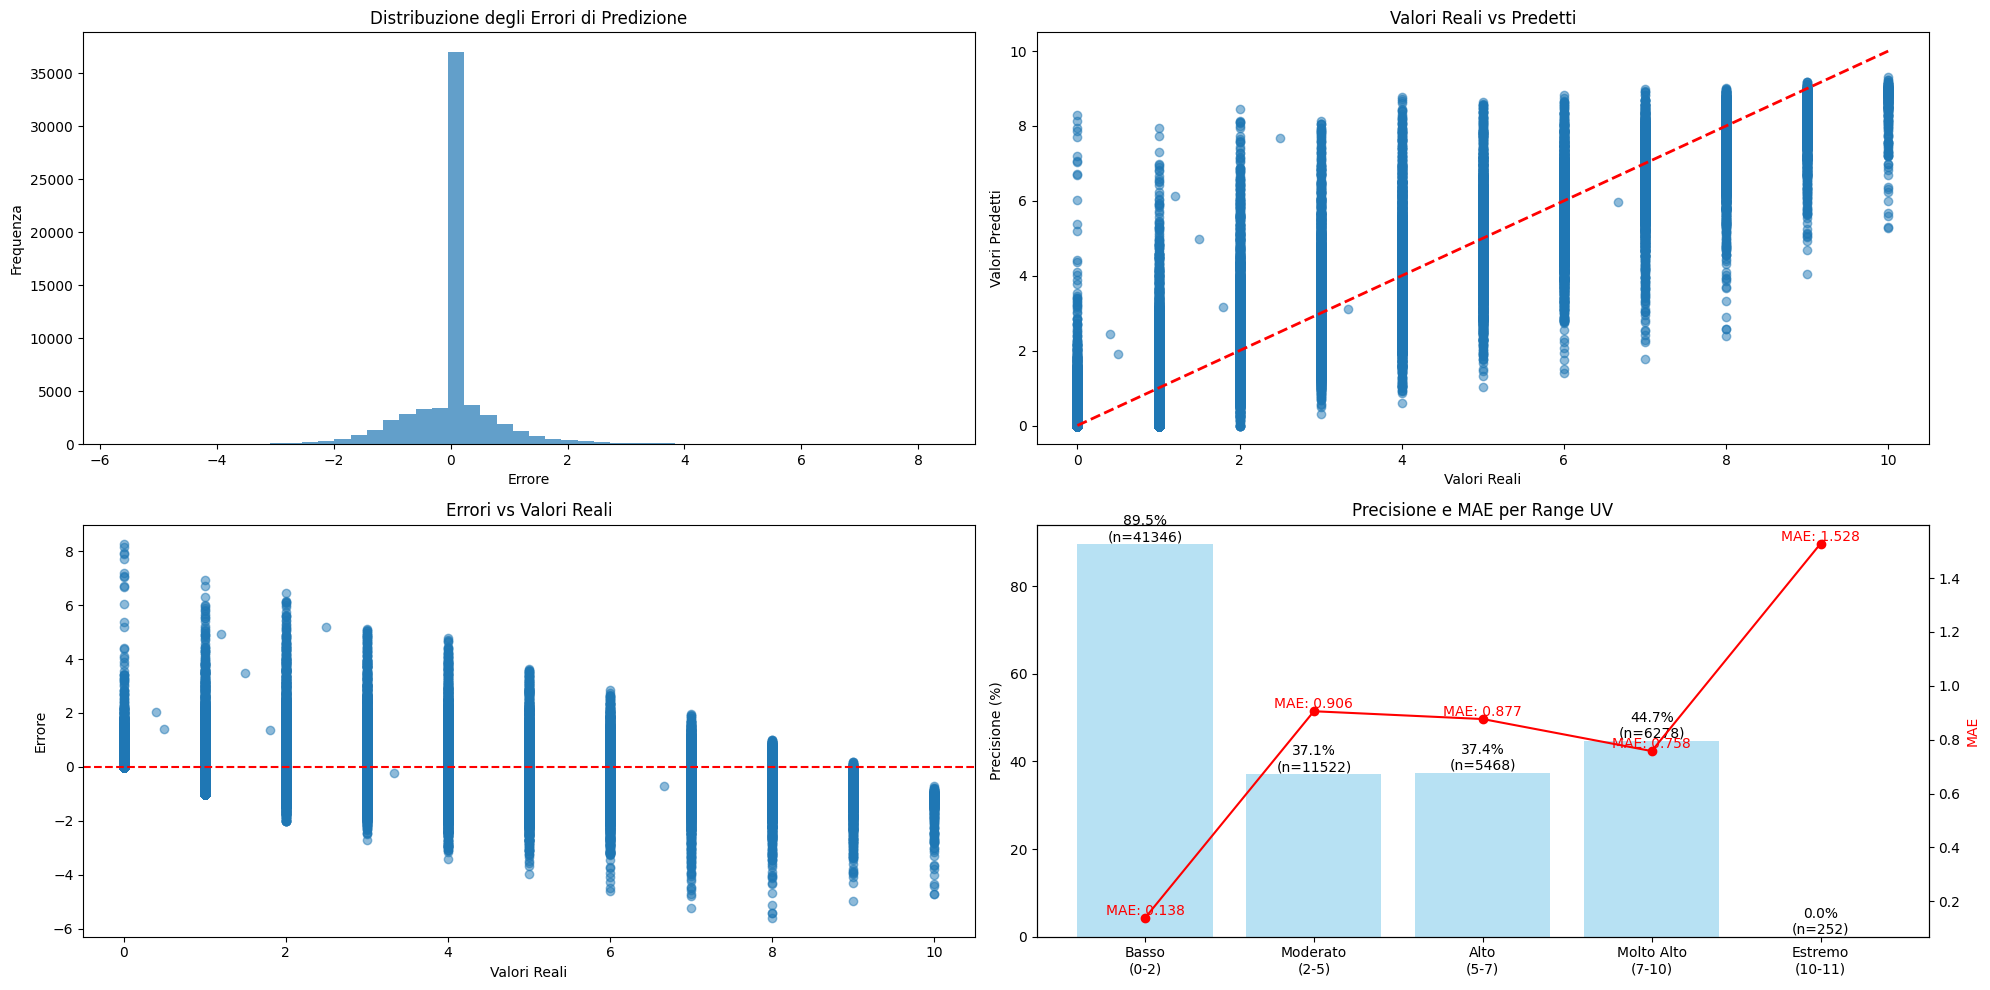


Matrice di Confusione per Livelli di Rischio UV:
            Basso  Moderato  Alto  Molto Alto  Estremo
Basso        2931        19     0        2128      390
Moderato       41     40299     0         995       11
Alto           13         0     0           0      239
Molto Alto    863      2454     0        8063      142
Estremo      1878         1     0         169     4230

Analisi Precisione Predizioni UV Index:
Precisione esatta (±0.1): 55.1%
Precisione entro 0.5 punti: 71.1%
Precisione entro 1.0 punti: 86.1%
Precisione livello di rischio: 85.6%

Analisi errori per livello UV:
MAE per UV Basso (0-2): 0.138 (n=41346)
MAE per UV Moderato (2-5): 0.906 (n=11522)
MAE per UV Alto (5-7): 0.877 (n=5468)
MAE per UV Molto Alto (7-10): 0.758 (n=6278)
MAE per UV Estremo (10-11): 1.528 (n=252)

Statistiche degli errori:
Media errori: 0.006
Deviazione standard errori: 0.783
Errore mediano: 0.000
95° percentile errore assoluto: 1.723

Distribuzione degli errori:
Predizioni entro ±0.5: 71.1%
Pre

In [12]:
def plot_advanced_prediction_analysis(y_true, y_pred, folder_name=None):
    """
    Funzione per visualizzare l'analisi degli errori di predizione e la precisione

    Parameters:
    -----------
    y_true : array-like
        Valori reali
    y_pred : array-like
        Valori predetti
    folder_name : str, optional
        Cartella dove salvare i plot. Se None, i plot non vengono salvati.
    """
    import os
    from datetime import datetime
    import seaborn as sns

    # Converti in array numpy 1D se necessario
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # Calcola gli errori
    errors = y_pred - y_true

    # Calcola accuracy per diversi livelli di tolleranza
    exact_accuracy = np.mean(np.abs(errors) < 0.1) * 100
    accuracy_05 = np.mean(np.abs(errors) <= 0.5) * 100
    accuracy_10 = np.mean(np.abs(errors) <= 1.0) * 100

    def get_risk_level(uv):
        if uv < 2:
            return 'Basso'
        elif uv < 5:
            return 'Moderato'
        elif uv < 7:
            return 'Alto'
        elif uv < 10:
            return 'Molto Alto'
        else:
            return 'Estremo'

    y_true_risk = [get_risk_level(x) for x in y_true]
    y_pred_risk = [get_risk_level(x) for x in y_pred]
    risk_accuracy = np.mean(np.array(y_true_risk) == np.array(y_pred_risk)) * 100

    # Crea la figura principale
    fig = plt.figure(figsize=(20, 10))

    # Plot 1: Distribuzione degli errori
    plt.subplot(2, 2, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Distribuzione degli Errori di Predizione')
    plt.xlabel('Errore')
    plt.ylabel('Frequenza')

    # Plot 2: Actual vs Predicted
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Valori Reali vs Predetti')
    plt.xlabel('Valori Reali')
    plt.ylabel('Valori Predetti')

    # Plot 3: Errori vs Valori Reali
    plt.subplot(2, 2, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Errori vs Valori Reali')
    plt.xlabel('Valori Reali')
    plt.ylabel('Errore')

    # Plot 4: Precisione per intervallo di UV
    plt.subplot(2, 2, 4)

    solarradiation_ranges = [(0, 2), (2, 5), (5, 7), (7, 10), (10, 11)]
    range_labels = ['Basso\n(0-2)', 'Moderato\n(2-5)', 'Alto\n(5-7)', 'Molto Alto\n(7-10)', 'Estremo\n(10-11)']

    accuracies = []
    counts = []
    mae_per_range = []

    for (low, high) in solarradiation_ranges:
        mask = (y_true >= low) & (y_true < high)
        if mask.any():
            mae = np.mean(np.abs(y_pred[mask] - y_true[mask]))
            mae_per_range.append(mae)
            count = np.sum(mask)
            counts.append(count)
            accuracy = np.mean(np.abs(y_pred[mask] - y_true[mask]) <= 0.5) * 100
            accuracies.append(accuracy)

    # Crea il grafico a barre con doppio asse y
    ax = plt.gca()
    bars = plt.bar(range_labels, accuracies, alpha=0.6, color='skyblue')
    plt.ylabel('Precisione (%)')
    plt.title('Precisione e MAE per Range UV')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.1f}%\n(n={counts[bars.index(bar)]})',
                 ha='center', va='bottom')

    ax2 = ax.twinx()
    line = ax2.plot(range_labels, mae_per_range, 'r-', marker='o', label='MAE')
    ax2.set_ylabel('MAE', color='red')

    for i, mae in enumerate(mae_per_range):
        ax2.text(i, mae, f'MAE: {mae:.3f}', color='red', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Salva la figura principale se è specificata una cartella
    if folder_name is not None:
        try:
            # Crea la cartella se non esiste
            os.makedirs(folder_name, exist_ok=True)

            # Genera il timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

            # Salva la figura principale
            main_plot_filename = os.path.join(folder_name, f'advanced_analysis_{timestamp}.png')
            plt.savefig(main_plot_filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot principale salvato come: {main_plot_filename}")

            # Crea e salva la matrice di confusione come plot separato
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_true_risk, y_pred_risk)
            risk_levels = ['Basso', 'Moderato', 'Alto', 'Molto Alto', 'Estremo']
            cm_df = pd.DataFrame(cm, columns=risk_levels, index=risk_levels)

            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Matrice di Confusione per Livelli di Rischio UV')
            plt.tight_layout()

            conf_matrix_filename = os.path.join(folder_name, f'confusion_matrix_{timestamp}.png')
            plt.savefig(conf_matrix_filename, dpi=300, bbox_inches='tight')
            print(f"Matrice di confusione salvata come: {conf_matrix_filename}")

        except Exception as e:
            print(f"\nErrore nel salvare i plot: {str(e)}")

    plt.show()

    # Stampa delle statistiche e analisi
    cm = confusion_matrix(y_true_risk, y_pred_risk)
    risk_levels = ['Basso', 'Moderato', 'Alto', 'Molto Alto', 'Estremo']
    cm_df = pd.DataFrame(cm, columns=risk_levels, index=risk_levels)

    print("\nMatrice di Confusione per Livelli di Rischio UV:")
    print(cm_df)

    print("\nAnalisi Precisione Predizioni UV Index:")
    print(f"Precisione esatta (±0.1): {exact_accuracy:.1f}%")
    print(f"Precisione entro 0.5 punti: {accuracy_05:.1f}%")
    print(f"Precisione entro 1.0 punti: {accuracy_10:.1f}%")
    print(f"Precisione livello di rischio: {risk_accuracy:.1f}%")

    print("\nAnalisi errori per livello UV:")
    solarradiation_ranges = [(0, 2, 'Basso'), (2, 5, 'Moderato'), (5, 7, 'Alto'),
                 (7, 10, 'Molto Alto'), (10, 11, 'Estremo')]

    for low, high, label in solarradiation_ranges:
        mask = (y_true >= low) & (y_true < high)
        if mask.any():
            mae = np.mean(np.abs(errors[mask]))
            n_samples = np.sum(mask)
            print(f"MAE per UV {label} ({low}-{high}): {mae:.3f} (n={n_samples})")

    print("\nStatistiche degli errori:")
    print(f"Media errori: {np.mean(errors):.3f}")
    print(f"Deviazione standard errori: {np.std(errors):.3f}")
    print(f"Errore mediano: {np.median(errors):.3f}")
    print(f"95° percentile errore assoluto: {np.percentile(np.abs(errors), 95):.3f}")

    print("\nDistribuzione degli errori:")
    thresholds = [0.5, 1.0, 1.5, 2.0]
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(errors) <= threshold) * 100
        print(f"Predizioni entro ±{threshold}: {within_threshold:.1f}%")


# Usa la funzione
plot_advanced_prediction_analysis(y_test, predictions, folder_name=folder_name)